# Google’s Neural Machine Translation System: Bridging the Gap between Human and Machine Translation (2016)

출처: [https://arxiv.org/pdf/1609.08144.pdf](https://arxiv.org/pdf/1609.08144.pdf)

## Abstract

Neural Machine Translation(NMT)은 자동화된 번역을 위한 end-to-end 학습 접근 방식으로, 기존의 phrase-based 번역 시스템의 많은 약점을 극복할 수 있습니다. 

NMT 시스템은 훈련과 번역, 추론 모두에서 비용이 많이 드는 것으로 알려져 있습니다. 또한, 몇몇 저자는 NMT 시스템이 특히 입력 문장에 희귀 단어가 포함된 경우 robustness가 부족하다고 주장했습니다. 이러한 문제는 정확성과 속도가 모두 필수적인 실제 배포 및 서비스에서 NMT를 사용하는 데 방해가 되었습니다. 여기에서는 이러한 많은 문제를 해결하려는 Google의 NMT 시스템인 GNMT를 제시합니다. 

이 모델은 8개의 인코더와 8개의 디코더 레이어가 있는 LSTM 네트워크로 구성되며, 디코더 네트워크에서 인코더로의 attention connections는 물론 residual connections을 사용합니다. 병렬 처리를 개선하여 훈련 시간을 줄이기 위해 attention 메커니즘은 디코더의 맨 아래 레이어를 인코더의 맨 위 레이어에 연결합니다. 최종 번역 속도를 가속화하기 위해 추론 계산 중에 low-precision arithmetic을 사용합니다. rare word 처리를 개선하기 위해 입력 및 출력 모두에 대해 단어를 제한된 공통의 subword 단위("wordpieces") 세트로 나눕니다. 

이 방법은 "character"로 구분된 모델의 유연성과 "word"로 구분된 모델의 효율성 사이에서 좋은 밸런스를 제공하고, rare word의 번역을 자연스럽게 처리하고, 궁극적으로 시스템의 전체 정확도를 향상시킵니다. beam search technique은 length-normalization 절차를 사용하고 coverage penalty를 사용합니다. 이는 소스 문장의 모든 단어를 포함할 가능성이 가장 높은 출력 문장의 생성을 장려하게 합니다. 

번역 BLEU 점수를 직접 최적화하기 위해 강화 학습을 사용하여 모델을 개선하는 것을 고려했지만, BLEU 점수의 향상이 사람의 평가에 반영되지 않는다는 것을 발견했습니다. WMT'14 English-to-French 및 English-to-German 벤치마크에서 GNMT는 SOTA에 대한 경쟁력 있는 결과를 달성합니다. 따로 준비해둔 간단한 문장 세트에 대해 사람이 나란히 평가하여 Google의 phrase-based 생산 시스템에 비해 번역 오류를 평균 60% 감소시킵니다.

## 1 Introduction

Neural Machine Translation (NMT)은 최근 전통적인 기계 번역 시스템의 많은 단점을 해결할 수 있는 유망한 접근 방식으로 도입되었습니다. NMT의 강점은 입력 텍스트에서 관련 출력 텍스트로의 매핑을 end-to-end 방식으로 직접 학습하는 능력에 있습니다.

하지만, 실제로 NMT 시스템은 phrase-based 번역 시스템보다 정확도가 더 낮았습니다. 이러한 원인은 학습 및 추론 속도가 느리고 rare word를 처리하는데 비효율적이며 때로는 소스 문장의 모든 단어를 번역하지 못하는 경우가 있기 때문입니다.

이 작업은 위의 문제에 대한 솔루션을 제공하는 것을 목표로 하는 Google의 프로덕션 NMT 시스템인 GNMT의 설계 및 구현을 제시합니다. 여기에서의 recurrent network는 LSTM(Long Short-Term Memory) RNN입니다. 여기서의 LSTM RNN는 8개의 레이어가 있으며 레이어 사이에  residual connections가 있어 gradient flow를 개선합니다. 병렬 처리를 위해 디코더 네트워크의 맨 아래 레이어에서 인코더 네트워크의 맨 위 레이어로 attention을 연결합니다. rare word를 효과적으로 처리하기 위해 시스템의 입력 및 출력에 subword 단위("wordpieces"라고도 함)를 사용합니다. wordpiecies 사용하면 단일 문자의 유연성과 전체 단어의 decoding 효율성 사이에서 균형을 잘 잡을 수 있으며, unknown 단어에 대한 특별 처리의 필요성도 피할 수 있습니다. 

또한, 언어별 조정 없이 여러 언어 쌍에 걸쳐 다양한 데이터 세트에서도 잘 수행됩니다. 동일한 구현을 사용하여 표준 벤치마크에서 이전의 SOTA와 비슷하거나 더 나은 결과를 얻을 수 있는 동시에 Google의 phrase-based 프로덕션 번역 시스템보다 크게 개선되었습니다.

GNMT는 영어 ↔ 프랑스어, 영어 ↔ 스페인어 및 영어 ↔ 중국어와 같은 여러 언어 쌍에서 이전 phrase-based 시스템과 비교하여 번역 오류를 60% 줄였습니다. 추가 실험을 통해 결과 번역 시스템의 품질이 일반 사람 번역가의 quality에 가까워짐을 알 수 있습니다.

## 3 Model Architecture

우리의 모델(figure 1)은 일반적인 sequence-to-sequence 학습 프레임워크와 attention을 따릅니다. 인코더 네트워크, 디코더 네트워크 및 attention 네트워크의 세 가지 구성 요소가 있습니다. 인코더는 소스 문장을 입력 기호당 하나의 벡터 목록으로 변환합니다. 이 벡터 목록이 주어지면 디코더는 특별한 문장 끝 기호 (EOS)가 생성될 때까지 한 번에 하나의 기호를 생성합니다. 인코더와 디코더는 어텐션 모듈을 통해 연결되어 디코더가 디코딩 과정에서 소스 문장의 다른 영역들에 집중할 수 있도록 합니다.


다음의 기호들은 이런 의미를 갖습니다.

- 굵은 소문자는 벡터 (e.g. **$v, o_i$**)
- 굵은 대문자는 행렬 (e.g. **$U, W$**)
- 필기체 대문자는 집합 (e.g. $\mathscr{V}, \mathscr{T}$)
- 대문자는 문장들 (e.g. X, Y)
- 소문자는 문장 내에서의 개별 기호 (e.g. $x_1, x_2$)

인코더는 다음 형식의 함수와 같습니다:

$$\begin{aligned}
P(Y \mid X) &=P\left(Y \mid \mathbf{x}_{1}, \mathbf{x}_{2}, \mathbf{x}_{\mathbf{3}}, \ldots, \mathbf{x}_{\mathbf{M}}\right) \\
&=\prod_{i=1}^{N} P\left(y_{i} \mid y_{0}, y_{1}, y_{2}, \ldots, y_{i-1} ; \mathbf{x}_{\mathbf{1}}, \mathbf{x}_{2}, \mathbf{x}_{\mathbf{3}}, \ldots, \mathbf{x}_{\mathbf{M}}\right)
\end{aligned}$$

여기서 $y_0$은 모든 문장 앞에 추가되는 "문장의 시작" 기호입니다. 추론하는 동안 소스 문장 인코딩과 지금까지 디코딩된 target 시퀀스가 주어지면 다음 기호의 확률을 계산합니다:

$$P\left(y_{i} \mid y_{0}, y_{1}, y_{2}, y_{3}, \ldots, y_{i-1} ; \mathbf{x}_{1}, \mathbf{x}_{2}, \mathbf{x}_{3}, \ldots, \mathbf{x}_{\mathbf{M}}\right)$$

또한, 여기서는 여러층의 LSTM RNN 모델을 사용하고 최종적으로 output에 나올 문장 확률 계산을 위해 softmax 함수를 이용합니다.

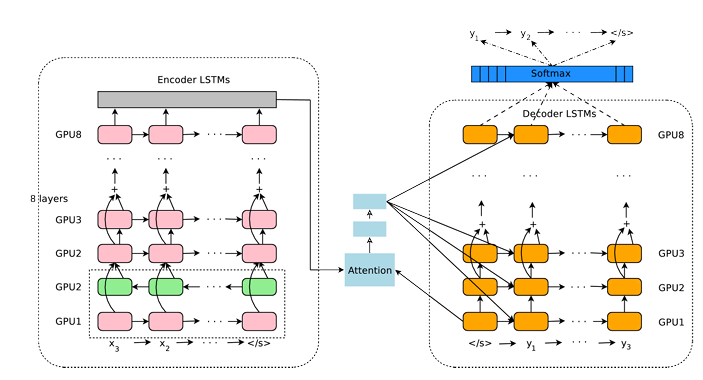
(Figure 1: 인코더 레이어의 밑바닥 층은 bi-directional. Residual connection은 인코더와 디코더의 맨 아래층에서 세번째 레이어에서 시작. 여기서는 8개의 LSTM 층을 사용)

현재 시점의 Attention context **$a_i$**는 다음 공식을 따라서 계산됩니다:

$$\begin{aligned}
s_{t} &=\text { AttentionFunction }\left(\mathbf{y}_{i-1}, \mathbf{x}_{t}\right) \quad \forall t, \quad 1 \leq t \leq M \\
p_{t} &=\exp \left(s_{t}\right) / \sum_{t=1}^{M} \exp \left(s_{t}\right) \quad \forall t, \quad 1 \leq t \leq M \\
\mathbf{a}_{i} &=\sum_{t=1}^{M} p_{t} \cdot \mathbf{x}_{t}
\end{aligned}$$

여기서 $AttentionFunction$은 하나의 hidden layer가 있는 feed forward network입니다.

### 3.1 Residual Connections

위에서 언급했듯이 깊게 쌓은 LSTM은 보통 얕은 모델보다 더 나은 정확도를 제공합니다. 그러나 단순히 LSTM의 더 많은 레이어를 쌓는 것은 특정 수의 레이어에만 작동하며, 그 이상에서는 네트워크가 너무 느려지고 학습하기 어려워지며, 이는 gradient exploding 혹은 vanishing gradient가 발생할 수 있습니다.

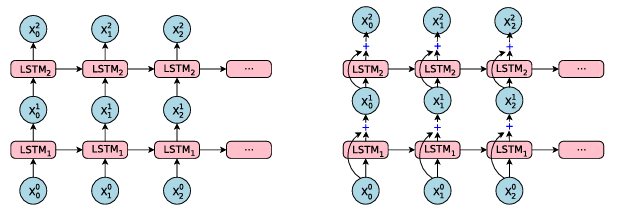
(Figure 2)

residual connection은 backward pass의 gradient flow을 크게 향상시켜 매우 깊은 인코더 및 디코더 네트워크를 훈련시킬 수 있습니다.

### 3.2 Bi-directional Encoder for First Layer

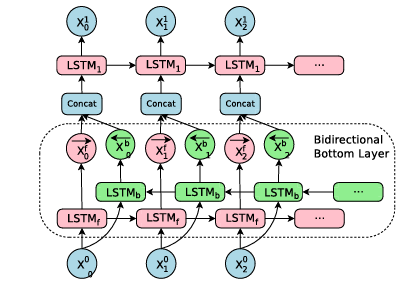
(Figure 3)

## 4 Segmentation Approaches

Neural Machine Translation 모델은 번역이 open vocabulary problem이 있음에도 불구하고 고정된 word vocabularies를 사용합니다. 이러한 문제 해결을 위한 방법은 크게 두가지가 있습니다:

1. 간단하게 rare word를 target으로 복사하는 것
2. subword units 사용하기

### 4.1 Wordpiece Model

- **Word:** Jet makers feud over seat width with big orders at stake 
- **wordpieces:** _J et _makers _fe ud _over _seat _width _with _big _orders _at _stake

("_"는 단어의 시작을 표시하기 위한 특별한 문자입니다.)

### 4.2 Mixed Word/Character Model

여기선 3개의 접두사가 있습니다: $<B>, <M> and <E>$

각각 단어의 시작, 중간, 끝을 나타냅니다.

예를 들어 $MiKi$라는 단어가 없다면 $<B>M <M>i <M>k <E>i$로 전처리 해줍니다. 접두사를 사용하면토큰화를 원래 단어로 되돌리는 것이 간단해집니다. 

## 9 Conclusion

이 논문에서는 정확도, 속도 및 robustness에 중요한 모든 기술을 포함하여 Google의 GNMT(신경 기계 번역) 시스템 구현에 대해 자세히 설명합니다. WMT'14 translation 벤치마크에서 번역 quality는 현재 게시된 모든 결과에 근접하거나 능가합니다.

특히, 이 GNMT 시스템은 이전의 phrase-based production system과 비교하여 여러 language pairs에서 번역 오류를 약 60% 감소시킵니다.